# Analysis of Mapper results

For every run the output of the Mapper algorithm is a simplicial complex. Compute its **persistent homology** (you can implement your own algorithm or use existing ones on the internet) and compare the resulting persistent diagrams. How are the diagrams connected to the original shapes?


### Working with sklearn dataset

In [43]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

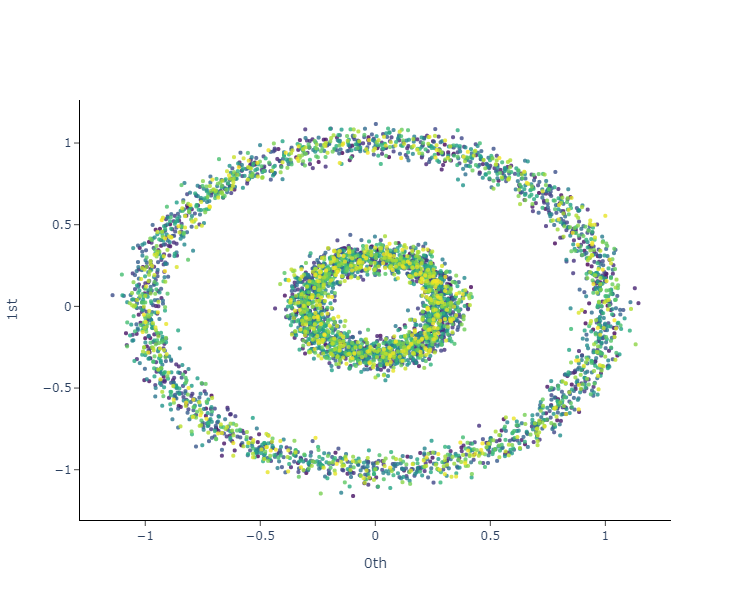

In [44]:
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

plot_point_cloud(data)

In [45]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

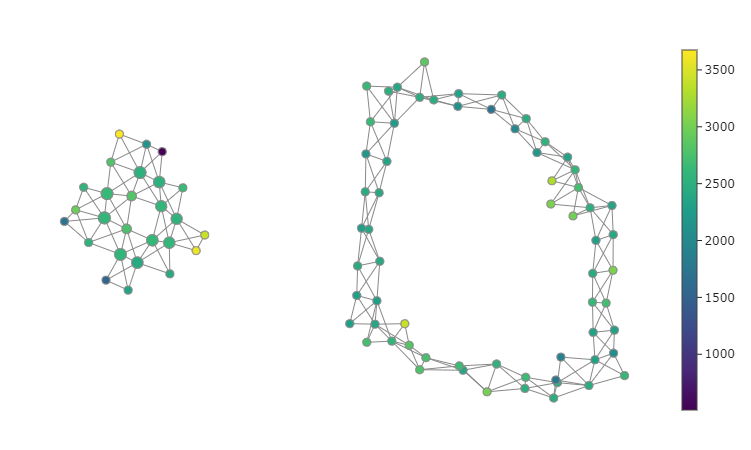

In [46]:
fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

In [47]:
graph_data = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
graph_data.shape

(90, 2)

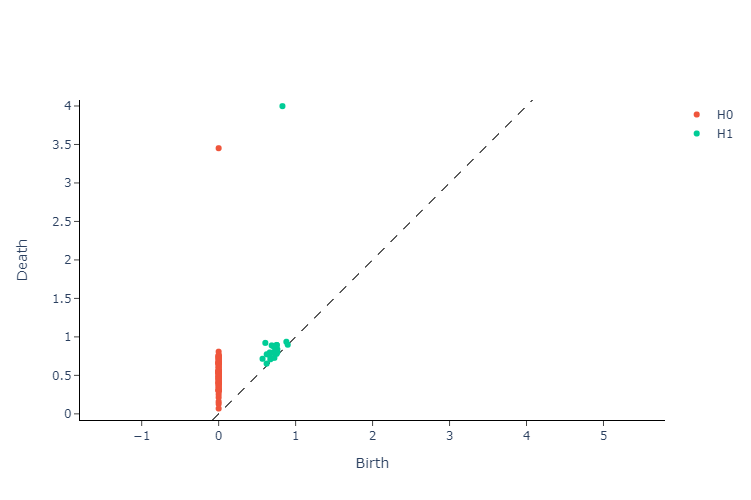

In [48]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

homology_dimensions = [0, 1]

persistence = VietorisRipsPersistence(
    # metrics: euclidean, manhattan, cosine
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    # number of jobs to use for the computation
    n_jobs=6,
    # Collapse edges to speed up H2 persistence calculation!
    collapse_edges=True,
)

diagram_basic = persistence.fit_transform(graph_data[None, :, :])

plot_diagram(diagram_basic[0])

### Working with dataset from csv file

In [49]:
import csv

data = []
with open('../shape2.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for i, row in enumerate(spamreader):
        if i > 0:
            data.append([float(row[1]), float(row[2]), float(row[3])])

df = pd.DataFrame(data, columns=["x", "y", "z"])
df.head()

x         y         z
0 -1.415462 -0.038724  4.690435
1 -1.051548 -2.424767  1.792992
2 -1.098418 -2.563128  1.538393
3  4.197488 -1.744636  3.037868
4  2.057012  0.026903  5.754537

In [52]:
plot_point_cloud(np.array(data))

In [53]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=["x", "y"])

# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)

# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

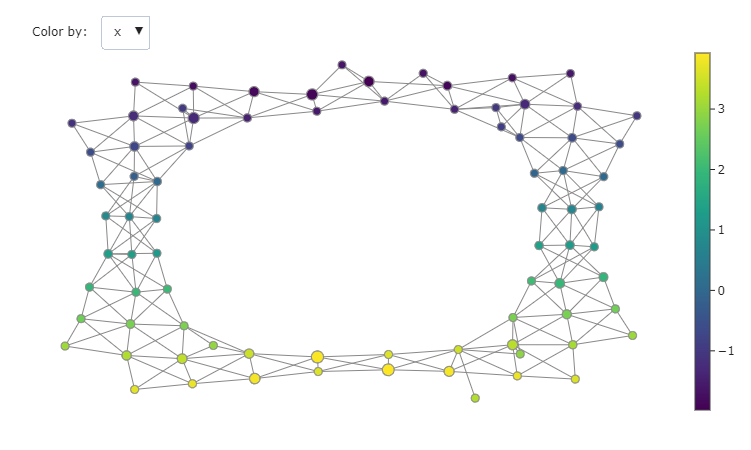

In [54]:
fig = plot_static_mapper_graph(pipe, df, color_data=df)
fig.show(config={'scrollZoom': True})

In [55]:
graph_data = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
graph_data.shape

(80, 2)

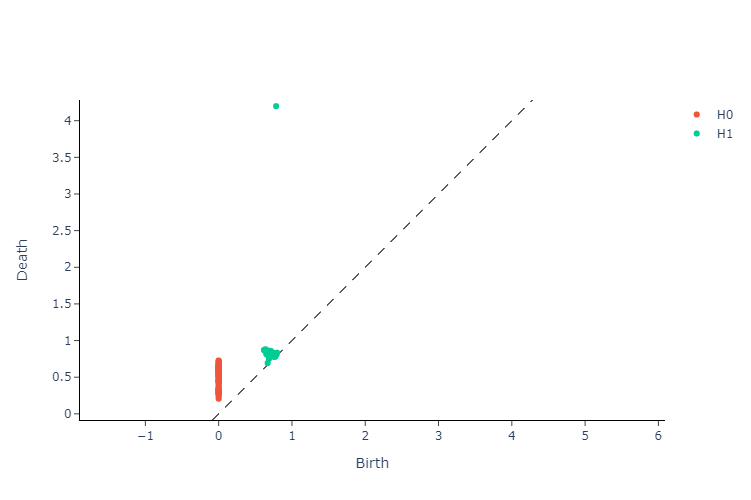

In [56]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

homology_dimensions = [0, 1]

persistence = VietorisRipsPersistence(
    # metrics: euclidean, manhattan, cosine
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    # number of jobs to use for the computation
    n_jobs=6,
    # Collapse edges to speed up H2 persistence calculation!
    collapse_edges=True,
)

diagram_basic = persistence.fit_transform(graph_data[None, :, :])

plot_diagram(diagram_basic[0])

### Working with openml dataset

In [3]:
# install openml
from openml.datasets.functions import get_dataset

df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

x         y         z           target
0  0.341007  0.318606  0.096725  human_arms_out9
1  0.329226  0.421601  0.056749  human_arms_out9
2  0.446869  0.648674  0.124090  human_arms_out9
3  0.314729  0.217860  0.070847  human_arms_out9
4  0.426678  0.919195  0.047609  human_arms_out9

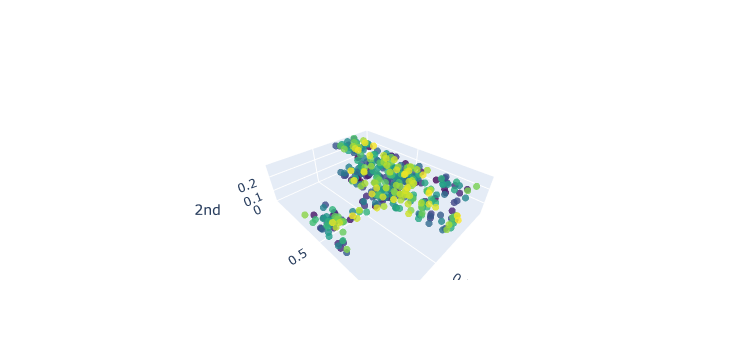

In [4]:
import numpy as np
from gtda.plotting import plot_point_cloud

point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape
plot_point_cloud(point_clouds[30])

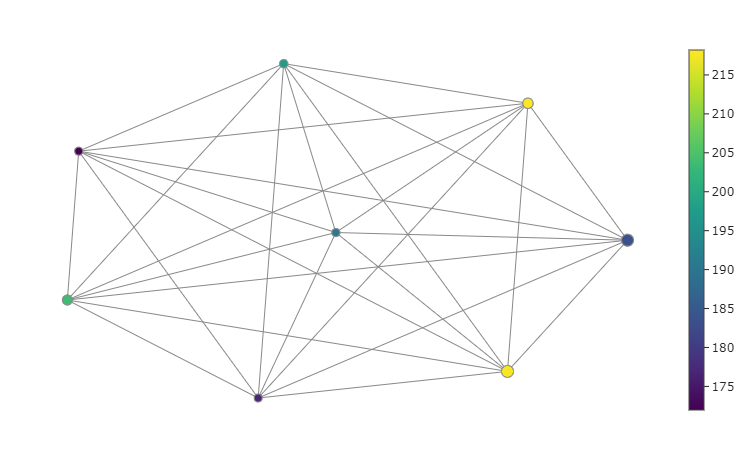

In [5]:
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph
)
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Define filter function – can be any scikit-learn transformer
#filter_func = Projection(columns=[0,1])
filter_func = PCA()
#filter_func = Eccentricity()
#filter_func = Entropy()
#filter_func = Projection()
#filter_func = UMAP(n_neighbors=5)

cover = CubicalCover(n_intervals=2, overlap_frac=0.2)

clusterer = DBSCAN(eps=10)

n_jobs = 1

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

fig = plot_static_mapper_graph(pipe, point_clouds[30])
fig.show(config={'scrollZoom': True})

In [6]:
mapped_points = []
for point_cloud in point_clouds:
    fig = plot_static_mapper_graph(pipe, point_cloud)
    graph_data = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
    mapped_points.append(graph_data)

In [7]:
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0,1,2]

persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
#persistence_diagrams = [persistence.fit_transform(X[None, :, :]) for X in mapped_points]
persistence_diagrams = persistence.fit_transform(mapped_points)

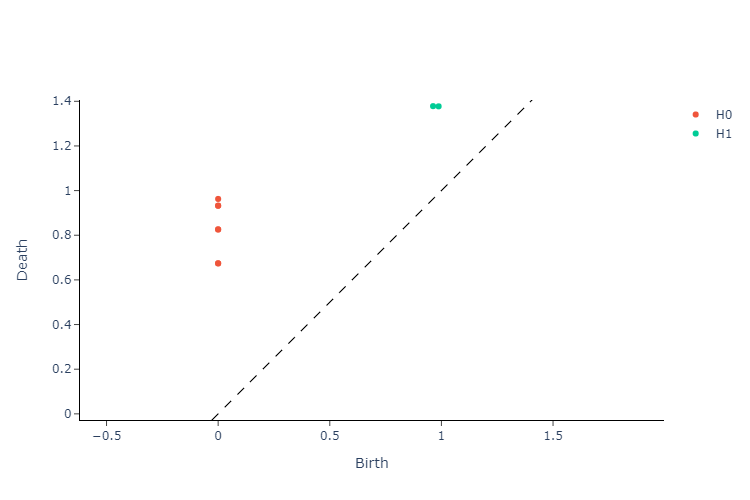

In [8]:
from gtda.plotting import plot_diagram

# Index - (human_arms_out, 0), (vase, 10), (dining_chair, 20), (biplane, 30)
index = 20

plot_diagram(persistence_diagrams[index])

### Comparing persistent diagrams

#### Previous example

0.25


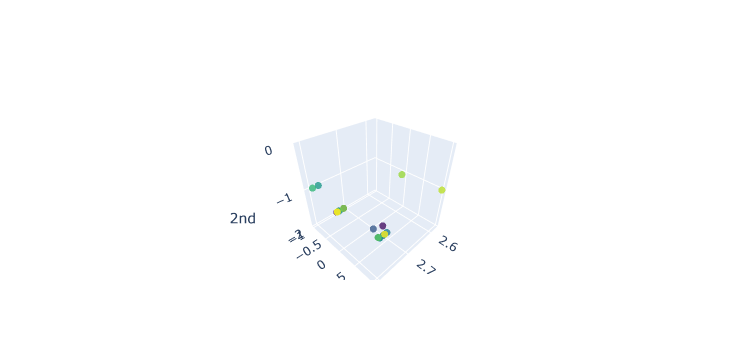

In [26]:
from gtda.pipeline import Pipeline
from gtda.diagrams import PersistenceEntropy
from sklearn.ensemble import RandomForestClassifier

steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

pipeline = Pipeline(steps)
X = pipeline.fit(persistence_diagrams, labels)

# use out-of-bag samples to estimate the generalization score
print(pipeline["model"].oob_score_)

persistence_entropy = PersistenceEntropy()
X = persistence_entropy.fit_transform(persistence_diagrams)

# Visualise feature matrix
plot_point_cloud(X)

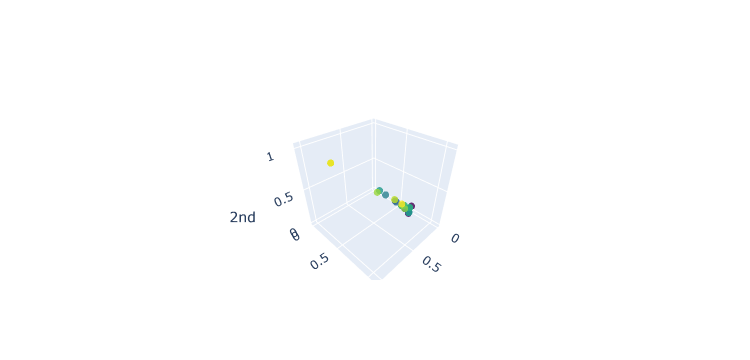

In [27]:
from gtda.diagrams import PairwiseDistance

pairwise_distance = PairwiseDistance(
    # 'bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette', 'heat', 'persistence_image'
    metric='landscape', 
    # dict or None
    metric_params=None, 
    # if None, transform returns for each pair of diagrams a vector of distances 
    # otherwise, the p-norm of these vectors with p equal to order
    order=1, 
    n_jobs=None
)

distance = pairwise_distance.fit_transform(persistence_diagrams)
plot_point_cloud(distance)

In [28]:
rf = RandomForestClassifier(oob_score=True)
x = rf.fit(distance, labels)

# use out-of-bag samples to estimate the generalization score
print(f"OOB score: {rf.oob_score_:.3f}")

OOB score: 0.225


#### Example with circles, spheres and toruses

In [29]:
import os
os.getcwd()
os.chdir("../tda-mapper")

from generate_data import make_point_clouds

point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=20, noise=0.5)
point_clouds_basic.shape, labels_basic.shape

((30, 400, 3), (30,))

In [30]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0,1])

# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)

# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

mapped_points = []
for point_cloud in point_clouds_basic:
    fig = plot_static_mapper_graph(pipe, point_cloud)
    graph_data = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
    mapped_points.append(graph_data)


In [31]:
from gtda.homology import VietorisRipsPersistence

# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

# try with mapped_points and point_clouds_basic
diagrams_basic = persistence.fit_transform(point_clouds_basic)

In [32]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

(30, 3)

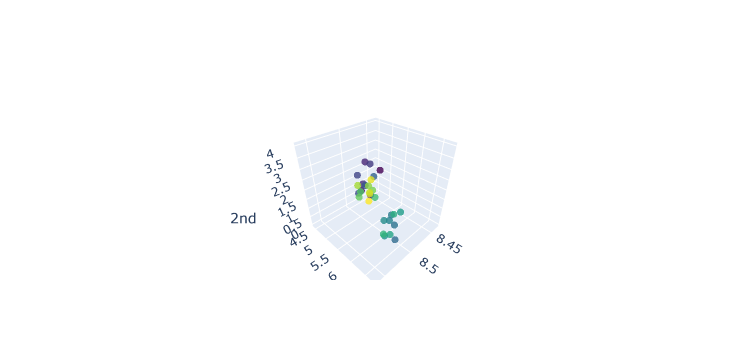

In [33]:
plot_point_cloud(X_basic)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

OOB score: 1.000


In [40]:
from gtda.diagrams import PairwiseDistance

pairwise_distance = PairwiseDistance(
    # 'bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette', 'heat', 'persistence_image'
    metric='landscape', 
    # dict or None
    metric_params=None, 
    # if None, transform returns for each pair of diagrams a vector of distances 
    # otherwise, the p-norm of these vectors with p equal to order
    order=2, 
    n_jobs=None
)

distances = pairwise_distance.fit_transform(diagrams_basic)
plot_point_cloud(distances)

In [41]:
rf = RandomForestClassifier(oob_score=True)
x = rf.fit(distances, labels_basic)

# use out-of-bag samples to estimate the generalization score
print(f"OOB score: {rf.oob_score_:.3f}")

OOB score: 1.000
